<a href="https://colab.research.google.com/github/sbooeshaghi/fluvax/blob/main/notebooks/basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/sbooeshaghi/fluvax.git

Cloning into 'fluvax'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 2), reused 15 (delta 1), pack-reused 0
Unpacking objects: 100% (30/30), done.


# A lower bound on COVID-19 vaccine distribution based on historical data of flu vaccine distribution

Author: **A. Sina Booeshaghi**
Date: **16 November 2020**

With the announcement the Pfizer and Moderna COVID-19 vaccine clinical trial data I was wondering how long potential vaccine distribution would be. I went and downloaded historical flu vaccine distribution data from the CDC (available [here](https://www.cdc.gov/flu/prevent/vaccine-supply-historical.htm)) and examined the results below.

An important note is that vaccine distribution data is not available for the 2019-2020 season. I called the CDC and reported this missing data. They were unable to locate it. I was told that they would "look into this" and that soneone would be "reaching out to me soon."

In [49]:
import time
now = time.time()

In [17]:
#@title Import python modules
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import glob
import datetime

import warnings
warnings.filterwarnings('ignore')

def yex(ax):
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def nd(arr):
    return np.asarray(arr).reshape(-1)

fsize=20

plt.rcParams.update({'font.size': fsize})

%config InlineBackend.figure_format = 'retina'

# Import the data and aggregate it into a dataframe

In [3]:
files = glob.glob("fluvax/data/*.txt")

In [4]:
data = []
for f in files:
  d = pd.read_csv(f, sep="\t", header=None, names=["date", "doses"])
  d["season"] = f.split("_")[-1].split(".")[0]
  data.append(d)

In [5]:
df = pd.concat(data)
df.index = pd.DatetimeIndex(df.date)
df["doy"] = df.index.dayofyear
df["yr"] = df.index.year
df = df.sort_values("doses")

In [6]:
plot_data = pd.pivot_table(df, index=['doy'],columns=['season'], values=['doses']).T

In [7]:
plot_data

doy                   1            3    ...          364          365
      season                            ...                          
doses 11-12           NaN          NaN  ...  131200000.0          NaN
      12-13           NaN          NaN  ...          NaN          NaN
      13-14           NaN  131200000.0  ...          NaN          NaN
      14-15           NaN          NaN  ...          NaN          NaN
      15-16   144900000.0          NaN  ...          NaN          NaN
      16-17           NaN          NaN  ...          NaN  143700000.0
      17-18           NaN          NaN  ...          NaN          NaN
      18-19           NaN          NaN  ...          NaN          NaN
      20-21           NaN          NaN  ...          NaN          NaN

[9 rows x 134 columns]

In [8]:
colors = [
    (0.2235294117647059,  0.23137254901960785, 0.4745098039215686 ),  # 393b79
    #(0.3215686274509804,  0.32941176470588235, 0.6392156862745098 ),  # 5254a3
    (0.4196078431372549,  0.43137254901960786, 0.8117647058823529 ),  # 6b6ecf
    #(0.611764705882353,   0.6196078431372549,  0.8705882352941177 ),  # 9c9ede
    (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939
    #(0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252
    (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b
    #(0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c
    (0.5490196078431373,  0.42745098039215684, 0.19215686274509805),  # 8c6d31
    #(0.7411764705882353,  0.6196078431372549,  0.2235294117647059 ),  # bd9e39
    (0.9058823529411765,  0.7294117647058823,  0.3215686274509804 ),  # e7ba52
    #(0.9058823529411765,  0.796078431372549,   0.5803921568627451 ),  # e7cb94
    (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
    #(0.6784313725490196,  0.28627450980392155, 0.2901960784313726 ),  # ad494a
    (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
    #(0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
    (0.4823529411764706,  0.2549019607843137,  0.45098039215686275),  # 7b4173
    #(0.6470588235294118,  0.3176470588235294,  0.5803921568627451 ),  # a55194
    (0.807843137254902,   0.42745098039215684, 0.7411764705882353 ),  # ce6dbd
    (0.8705882352941177,  0.6196078431372549,  0.8392156862745098 ),]  # de9ed6

# Analysis

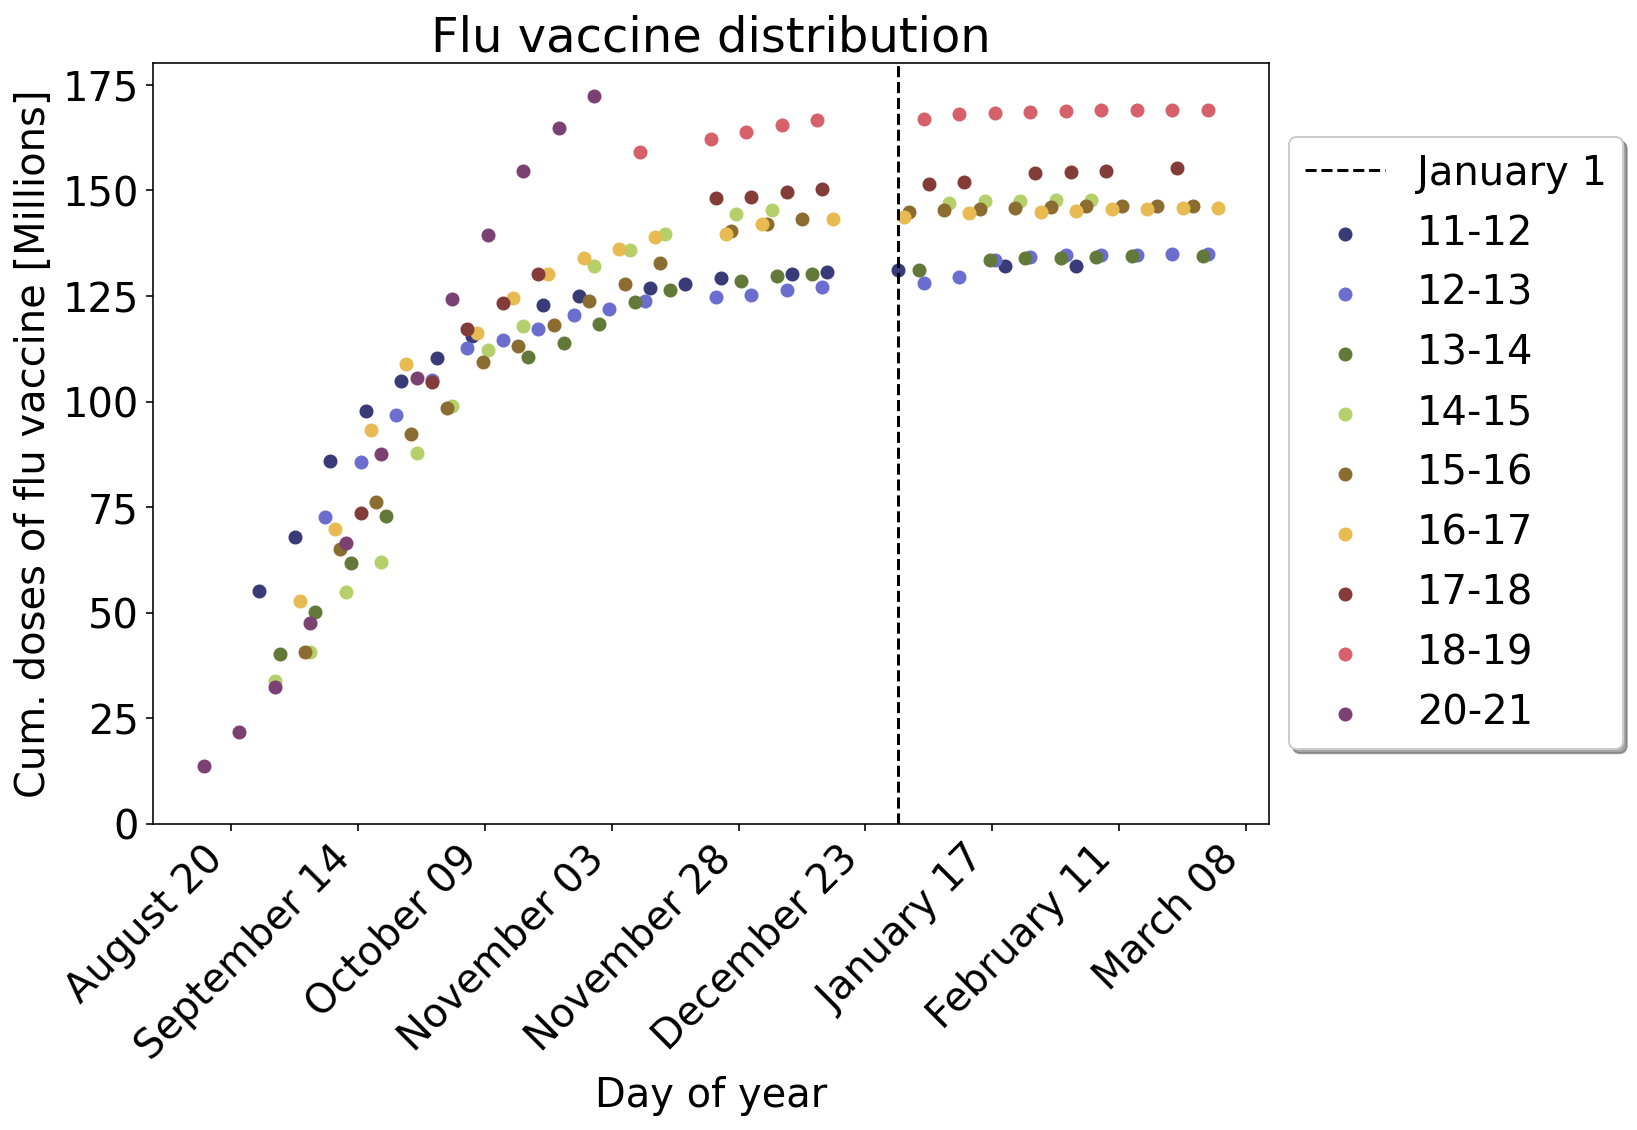

In [51]:
#@title Flu vaccine distribution typically occurs over a period of 7 months, beginning in August and ending at the start of March.
fig, ax = plt.subplots(figsize=(10, 7))

xdays = plot_data.columns.values
xx = nd([datetime.datetime.strftime(datetime.datetime.strptime(str(d), '%j'), "%B %d") for d in xdays])
x = (xdays-365/2)%365

yvals = plot_data.values/10**6

for idx, (y, m, s) in enumerate(zip(yvals, np.isnan(yvals), plot_data.index.get_level_values("season"))): 
  ax.scatter(x[~m],y[~m], color=colors[idx], label = f"{s}")

ax.axvline(x=(365/2)%365-1, label="January 1", color="k", linestyle="--")

fig.canvas.draw()

labels = [int((int(i.get_text())-365/2)%365) for i in ax.get_xticklabels()]
new_labels = [datetime.datetime.strftime(datetime.datetime.strptime(str(l), "%j"), "%B %d") for l in labels]

ax.set(**{
    "xlabel": "Day of year",
    "ylabel": "Cum. doses of flu vaccine [Millions]",
    "ylim": 0,
    "title": "Flu vaccine distribution"
})
ax.set_xticklabels(new_labels, rotation=45, ha="right")
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", shadow=True)
fig.show()

In [10]:
def func(x, a, b, c):
    return c/(1+ a*np.exp(-b * x))

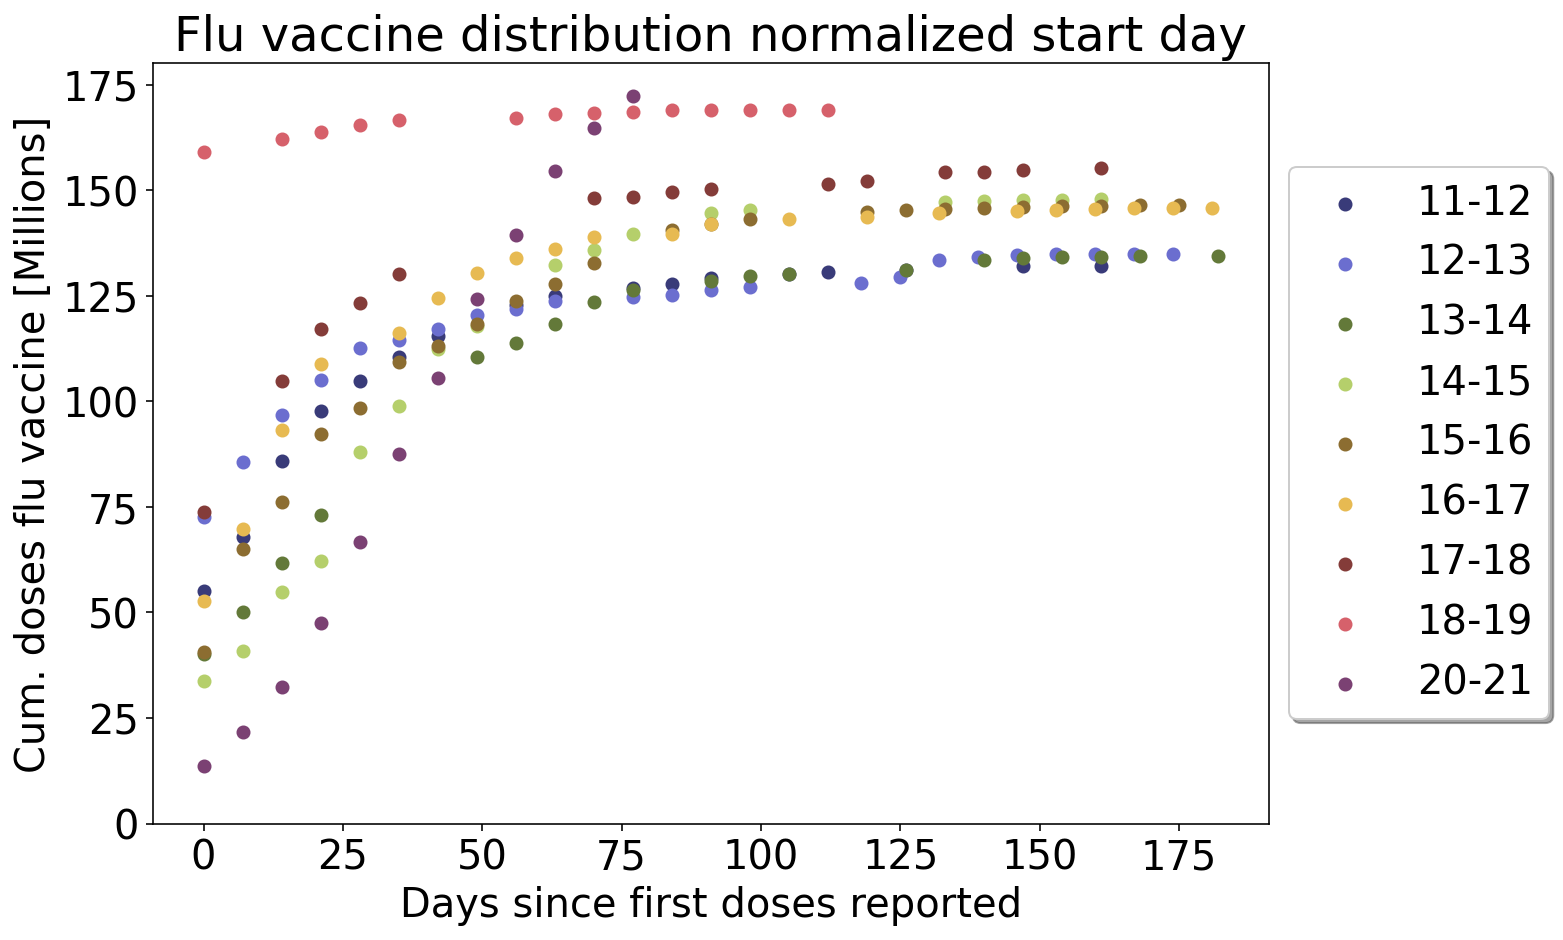

In [52]:
#@title Normalizing the start day we see that overall flu vaccine distribution has been increasing over time
fig, ax = plt.subplots(figsize=(10, 7))

xdays = plot_data.columns.values

x = (xdays-365/2)%365

yvals = plot_data.values/10**6

for idx, (y, m, s) in enumerate(zip(yvals, np.isnan(yvals), plot_data.index.get_level_values("season"))): 
  xt = x[~m].astype(float)
  yt = y[~m].astype(float)

  nx = xt - min(xt)

  ax.scatter(nx, yt, color=colors[idx], label = f"{s}")


ax.set(**{
    "xlabel": "Days since first doses reported",
    "ylabel": "Cum. doses flu vaccine [Millions]",
    "ylim": 0,
    "title": "Flu vaccine distribution normalized start day"
})

ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", shadow=True)

fig.show()

In [12]:
def func(x, a, b, c):
  return a*(1-b*np.exp(-c*x))

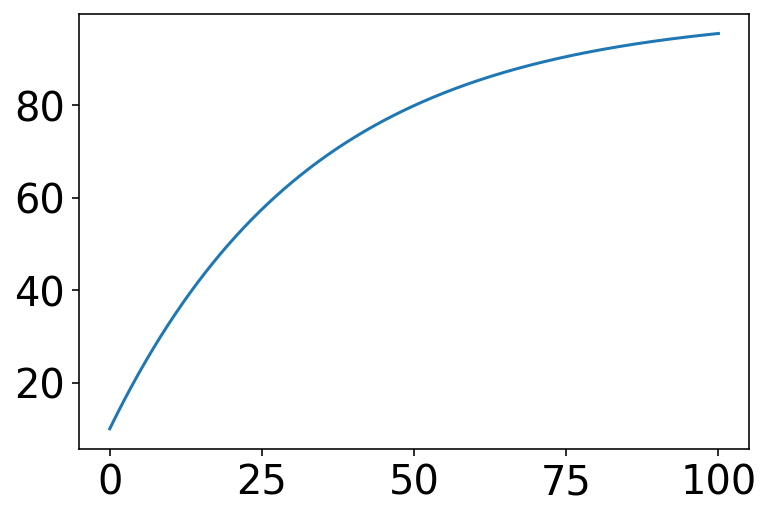

In [13]:
x = np.linspace(0, 100, 1000)
y = func(x, 100,.9,0.03)
plt.plot(x,y)

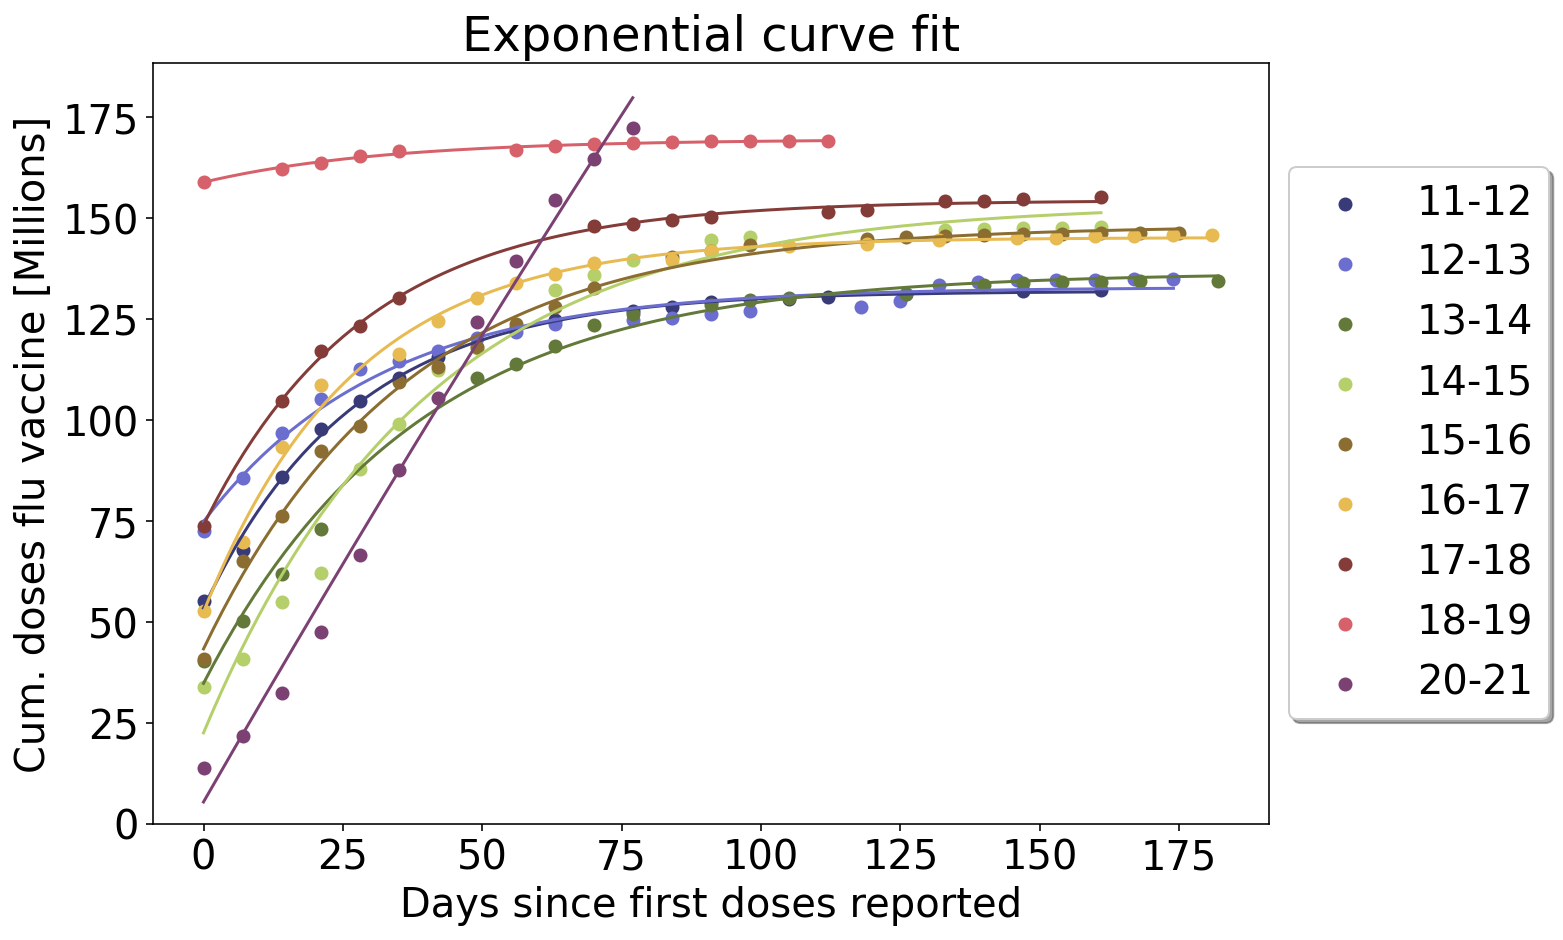

In [53]:
#@title We can model flu vaccine distribution as an exponential 
fig, ax = plt.subplots(figsize=(10, 7))

xdays = plot_data.columns.values

x = (xdays-365/2)%365

yvals = plot_data.values/10**6
params = np.zeros((yvals.shape[0],3))

for idx, (y, m, s) in enumerate(zip(yvals, np.isnan(yvals), plot_data.index.get_level_values("season"))): 
  xt = x[~m].astype(float)
  yt = y[~m].astype(float)

  nx = xt - min(xt)
  
  popt, pcov = curve_fit(func, nx, yt,p0=[140, 1,.01],maxfev=1000)
  newx = np.linspace(min(nx), max(nx), 200)

  ax.scatter(nx, yt, color=colors[idx], label = f"{s}")
  ax.plot(newx, func(newx, *popt), color=colors[idx])

  params[idx] = popt

ax.set(**{
    "xlabel": "Days since first doses reported",
    "ylabel": "Cum. doses flu vaccine [Millions]",
    "ylim": 0,
    "title": "Exponential curve fit"
})

ax.legend(bbox_to_anchor=(1, 0.5), loc="center left", shadow=True)

fig.show()

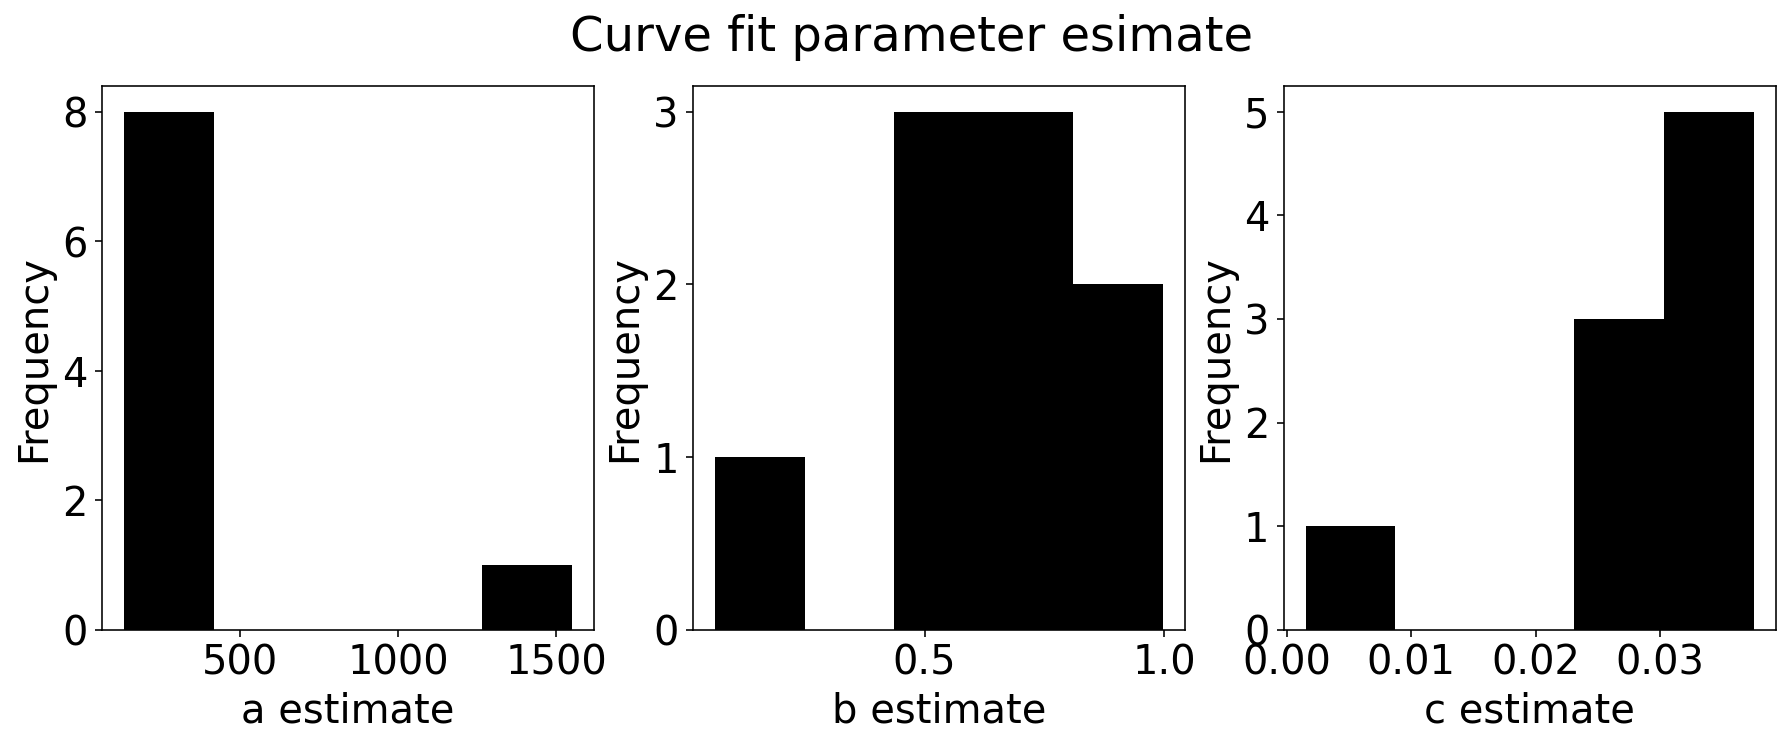

In [55]:
#@title We now have a distribution on each parameters of the fit for each season
fig, axs = plt.subplots(figsize=(15,5), ncols=3)
fig.suptitle("Curve fit parameter esimate")


ax = axs[0]
labels = ["a", "b", "c"]

for idx, ax in enumerate(axs):
  x = params[:,idx]
  ax.hist(x,bins=5, color="k")
  ax.set(**{
      "xlabel": f"{labels[idx]} estimate",
      "ylabel": "Frequency",
  })


fig.show()

In [56]:
# Here I use the US population for 2020
US_pop =  328_200_000

In [57]:
from scipy.spatial import ConvexHull

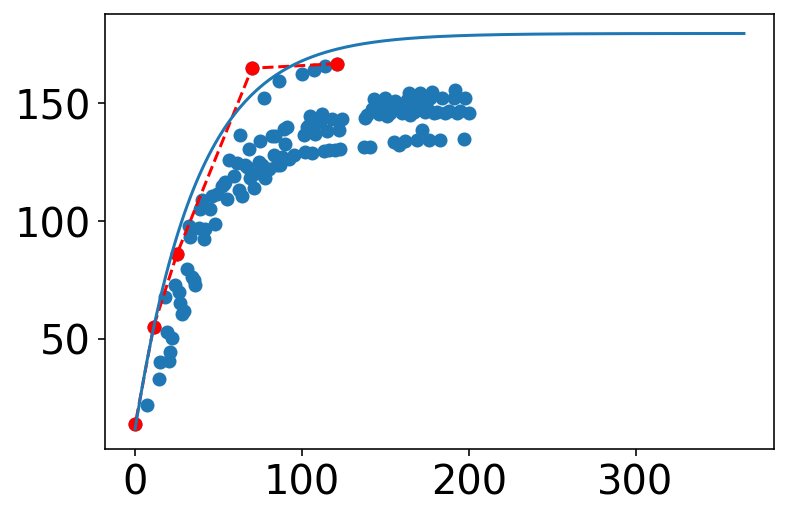

In [140]:
#@title Fit the model to the convex hull
yy = np.nanmean(yvals, axis=0)
h = ConvexHull(np.vstack([nx, yy]).T)

x = h.points[h.vertices,0][:5]
y = h.points[h.vertices,1][:5]

popt, pcov = curve_fit(func, x, y,  p0=[140, 1,.01],  maxfev=5000)
plt.plot(x, y, 'ro--')


plt.plot(newx, func(newx, *popt))

plt.scatter(nx, yy)
plt.show()

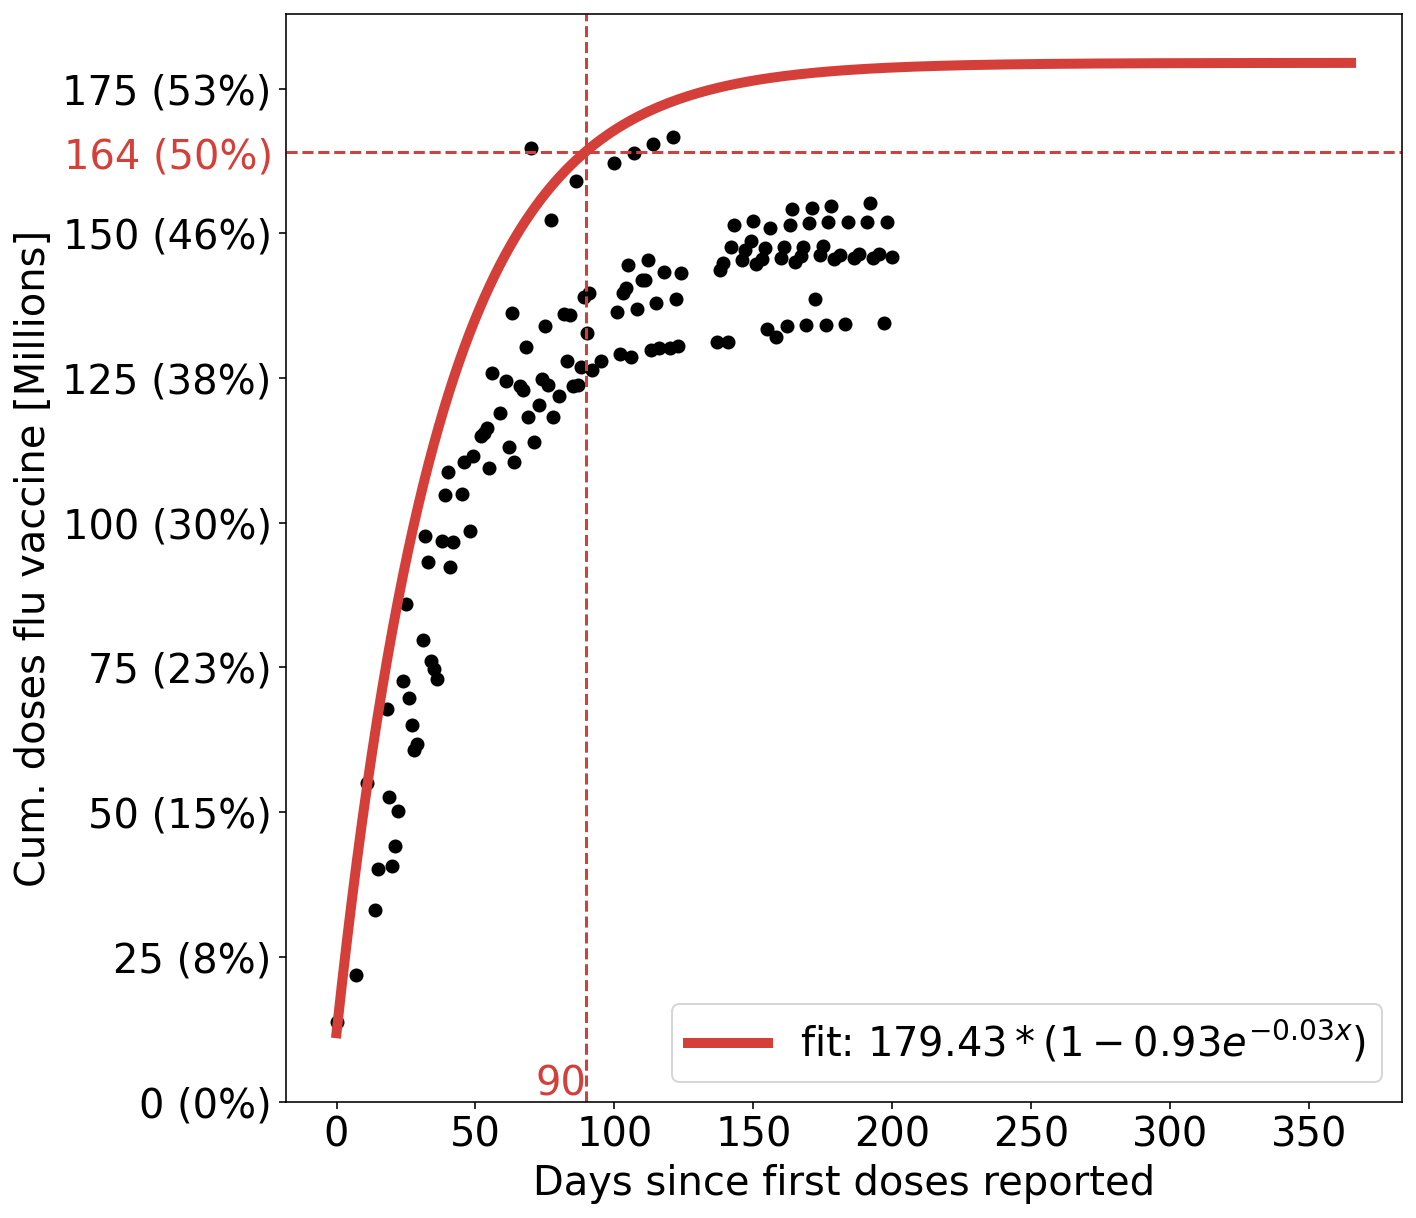

In [137]:
#@title We estimate it will take 90 days to distribute enough vaccines to vaccinate 50% of the US population
fig, ax = plt.subplots(figsize=(10, 10))

color="#D43F3A"

xdays = plot_data.columns.values

x = (xdays-365/2)%365
y = np.nanmean(yvals, axis=0)
ytop = np.nanmean(yvals, axis=0) + np.nanstd(yvals, axis=0)
ybot = np.nanmean(yvals, axis=0) - np.nanstd(yvals, axis=0)

nx = x - min(x)

ax.scatter(nx,y, color="k")


# plot the convex hull
h = ConvexHull(np.vstack([nx, y]).T)
x = h.points[h.vertices,0][:5]
y = h.points[h.vertices,1][:5]

popt, pcov = curve_fit(func, x, y, p0=[140, 1,.01],  maxfev=5000)
label = f"fit: ${popt[0]:,.2f}*(1-{popt[1]:,.2f}e^{{-{popt[2]:,.2f}x}})$"
ax.plot(newx, func(newx, *popt), color=color, linewidth=5, label=label)

nppl = US_pop/2/1000000.
ax.axhline(y=nppl, color=color, linestyle="--")
xl = newx[func(newx, *popt) >=nppl][0]
ax.axvline(xl, color=color, linestyle="--")
ax.text(-98, nppl-3, f"{nppl:.0f} (50%)", color=color)
ax.text(xl, 1, f"{xl:,.0f}",color= color, ha="right")

ax.set(**{
    "ylim": 0,
    "xlabel": "Days since first doses reported",
    "ylabel": "Cum. doses flu vaccine [Millions]",
})
fig.canvas.draw()

ax.set_yticklabels([f"{i.get_text()} ({float(i.get_text())/US_pop*100*1000000:,.0f}%)" for i in ax.get_yticklabels()])


ax.legend(loc="lower right")

fig.show()

In [50]:
print("This notebook took {:.2f} seconds to run.".format(time.time()-now))

This notebook took 11.73 seconds to run.
